# Vector Semantics

The purpose of this project is to implement TF-IDF (Term Frequency Inverse Document Frequency) in order to produce vector representations of words and see how they capture information about their context. Once we do that, we can go on to find the closest words for a given input word (here, closeness refers to the words that are most likely to appear in the context of the input word).

Let's import the required libraries and load the data for preparing our word vectors. We are going to load a list of movie plot summaries (http://www.cs.cmu.edu/~ark/personas/) and use that as our corpus.

In [1]:
import csv
from collections import Counter, defaultdict
import math
import heapq

def load_data():
    """
    Loads the data and returns a list of summaries.
    """
    summaries = []
    with open('plot_summaries_tokenized.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        summaries = [data['SUMMARY'].strip() for data in reader]
    return summaries

SUMMARIES = load_data()
SUMMARY_COUNT = len(SUMMARIES)

We have ~42000 summaries containing ~13000000 words. We will now proceed by creating a vocabulary and will limit its size to something computationally feasible.

## Creating a Vocabulary

In [2]:
VOCAB_SIZE = 50000
def create_vocabulary(documents):
    """
    This function takes in a list of documents and returns a
    vocabulary and word list of most frequently appearing VOCAB_SIZE words.
    
    :param documents: list of strings
    :return word_list: A list most frequently appearing unique VOCAB_SIZE words.
    :return vocab: A dictionary where key is the word and value is the word's index in word_list
    
    """
    word_list = []
    vocab = {}
    
    c = Counter()
    for doc in documents:
        c.update(doc.split())
        
    idx = 0
    for word, _ in c.most_common(VOCAB_SIZE):
        word_list.append(word)
        vocab[word] = idx
        idx += 1
        
    return word_list,vocab

WORDS,VOCAB = create_vocabulary(SUMMARIES)

## Calculating Term Frequencies

Following from [§6.3.1 Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/6.pdf), for a term frequency matrix $tf$ each element $tf_{t,d}$ is defined as follows 

$$ \begin{equation*}
    tf_{t,d} = \begin{cases}
               1 + log_{10}\text{count(t,d)}              & \text{if count}(t,d) > 0\\
               0 & \text{otherwise}
           \end{cases}
\end{equation*} $$

Instead of considering the entire document for obtaining the context of a single word, it is more common to use a smaller context. Like in [§6.3.2 Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/6.pdf), instead of a __term-document__ matrix, we will calculate the __term-context__ matrix for all the words in the vocabulary.

For a word $w_{i}$ and window size $k$, we define the context of $w_i$, $C(w_i,k)$ as the window of k words before and after that word in all the documents. If the defined window exceeds the document length, only consider the the portion till the beginning/end of the document.

We define a single element of the __term-context__ matrix, 
$$ \begin{equation*}
    tc[w_1][w_2] = \begin{cases}
               1 + log_{10}\text{count}(w_2,C(w_1,k))              & \text{if count}(w_2,C(w_1,k)) > 0\\
               0 & \text{otherwise}
           \end{cases}
\end{equation*} $$

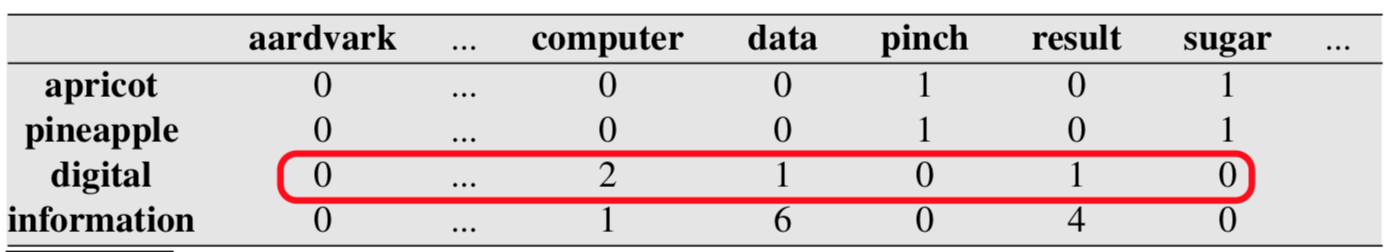



In [3]:
def term_frequencies(documents,vocab,k):
    """
    This function returns a dictionary of dictionary with each 
    tf[w1][w2] = 1 + log(number of times the word w2 occurs in context of word w1. (where w1,w2 belong to the vocab)) 
    or 0 (as defined above)
    
    :param documents: list of strings
    :param vocab: the vocabulary with vocab[word] = index
    :return tf: A dictionary where tf[word1][word2] = count of word2's occurences in word1's context window
    """
    tf = {}
    d = defaultdict(lambda: defaultdict(int))
    for doc in documents:
        word_list = doc.split()
        for idx, w1 in enumerate(word_list):
            if not w1 in vocab:
                continue
            for i in range(1, k+1):
                if not (idx - i) < 0:
                    w2 = word_list[idx - i]
                    if w2 in vocab:
                        d[w1][w2] += 1
                if not (idx + i) >= len(word_list):
                    w2 = word_list[idx + i]
                    if w2 in vocab:
                        d[w1][w2] += 1
                        
    for w1, dictionary in d.items():
        w1_dict = {}
        for w2, count in dictionary.items():
            w1_dict[w2] = 1 + math.log10(count)
        tf[w1] = w1_dict
    
    return tf

In [4]:
WINDOW_SIZE = 5
tf_matrix = term_frequencies(SUMMARIES,VOCAB,WINDOW_SIZE) # This takes a while to run...

## Calculating Document Frequencies

We now calculate the document frequency vector. The document frequency for a word is the number of documents (__contexts__ in our case) that the word appears in. For a word $t$, window size $k$ and context $C(t,k)$, the Document Frequency $df_t$ is defined as number of contexts the word $t$ occurs in.

In [5]:
def document_frequencies(tf_matrix):
    """
    This function takes in a tf-matrix and returns a dictionary
    with df scores for each word in the matrix.
    
    :param tf: A dictionary where tf[w1][w2] = 1 + log(number of times the word w2 occurs in context of word w1)
    :return df_scores: A dictionary with df_scores[word] = the df score of the word defined as above
    """
    df_scores = defaultdict(int)
    for word in WORDS:
        for w2 in tf_matrix[word].keys():
            df_scores[w2] += 1
            
    return df_scores

In [6]:
df_vector = document_frequencies(tf_matrix)

## Computing the TF-IDF Matrix

Following from [§6.5 Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/6.pdf), we will now calculate our TF-IDF matrix by re-weighing the term frequencies with the inverse document frequencies. For a word $t$ and $N$ documents, $idf_t$ is defined as: 

$$idf_{t} = log_{10}(\frac{N}{df_t})$$

Note that $N$ here equals to the number of contexts.

After calculating $idf$, we will calculate the tf-idf matrix. For a term $t$ and a document $d$, each term $w_{t,d}$ is defined as,

$$ w_{t,d} = tf_{f,d} \text{ x } idf_{t} $$

In [7]:
def tfidf(tf,df,vocab_size):
    """
    This function takes a term-frequency matrix and a document frequency 
    dictionary and returns a term-frequency matrix with each word vector
    reweighed by the idf (as defined above). 
    
    :param tf: term frequency matrix 
    :param df: document frequency dictionary
    :param vocab_size: size of the vocabulary
    
    :return tf: the reweighed tf matrix
    """
    for word, df_val in df.items():
        idf = math.log10(vocab_size / df_val)
        for w2 in tf[word].keys():
            tf[word][w2] *= idf
            
    return tf

In [8]:
tfidf_matrix = tfidf(tf_matrix,df_vector,VOCAB_SIZE)

## Finding the top K-nearest words

Using cosine similarity as a measure of distance [§6.4 Jurafsky & Martin](https://web.stanford.edu/~jurafsky/slp3/6.pdf), we will now find the closest words to a certain word. We define cosine similarity as, $$cosine(\overrightarrow{v},\overrightarrow{w}) = \frac{\overrightarrow{v} \cdot \overrightarrow{w}}{\vert v \vert \vert w \vert}$$

In [9]:
def k_nearest_tfidf(tfidf_matrix,word,vocab,k):
    """
    The function takes in a matrix and a word and returns a list of the indices
    of the words from the matrix which are closest to the argument word.
    :param tfidf_matrix: the tfidf matrix
    :param word: the word from which the distances are calculated against the vocab
    :param vocab: the vocabulary
    :param k: size of the results list
    
    :return result: the list of indices of elements, in ascending order of their distances. Size of this list = k.
    """
    distances = []
    
    input_dict = tfidf_matrix[word]
    input_norm = 0
    for val in input_dict.values():
        input_norm += val**2
    input_norm = math.sqrt(input_norm)
    
    for check_word in WORDS:
        if check_word == word:
            continue
        check_dict = tfidf_matrix[check_word]
        numerator = 0
        norm = 0
        for w2, w2_value in check_dict.items():
            if w2 in input_dict:
                numerator += w2_value * input_dict[w2]
            norm += w2_value**2
        distances.append((numerator / (math.sqrt(norm) * input_norm), check_word))
    
    return [vocab[x] for _, x in heapq.nlargest(k, distances)]

Let's find 15 words closest to 'love'.

In [10]:
print([WORDS[i] for i in k_nearest_tfidf(tfidf_matrix,'love',VOCAB,15)])

['she', 'her', 'not', 'this', 'about', 'father', 'life', 'also', 'She', 'who', 'when', 'has', 'mother', 'him', 'for']


Looks like it works! Let's try something more interesting like 'Batman'.

In [11]:
print([WORDS[i] for i in k_nearest_tfidf(tfidf_matrix,'Batman',VOCAB,10)])

['Joker', 'Superman', 'Robin', 'Bruce', 'vampire', 'Dracula', 'villains', 'Gotham', 'Gordon', 'monster']


Wow, quite accurate!